In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
Path.BASE_PATH = path

In [5]:
# create training datasets for both the threes and 7s. This will create a list of paths where the files are located.
# Note these are not actually downloading the images themselves to memory, just a list of relative paths.
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()

### Next step is to create a tensor for both the training and validation sets so that PyTorch can ingest them.

In [6]:
# We want to use list comprehension instead of for loop which is super slow to take advantage of the GPU 
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

## Now we have two list of three images and seven images stored in memory. Let's check the third object of our three's list

<AxesSubplot:>

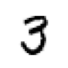

In [7]:
show_image(three_tensors[2])

In [8]:
# next convert the two lists of images into tensors with the correct shape and number of dimensions (we need 3: 28x28xn where n is number of images)
# in order to do that we use torch.stack 
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [9]:
## combine threes and sevens into one master training dataset using concatenate 
## now we have to convert the list of images into a tensor with the right shape 
## we use .view to collapse the tensor into a 2 dimensional one instead of 3 dimensional as that is what pytorch expects
## .view has a special parameter -1 that says make the axis as big as possible to fit the data
train_x = torch.cat([stacked_sevens, stacked_threes]).view(-1, 28*28)

In [10]:
train_x.shape

torch.Size([12396, 784])

In [11]:
# Next, we need to add a label so we have a target. That becomes our "y" or independent variable.
# let's `1` for 3s and `0` for 7s:
# we use unsqueeze to make this a one dimensional tensor instead of 0 (think this is a column now like our x training dataset)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

### So now we have a tensor with all our X (Dependent) datapoints and a tensor with the target labeled as a `1` for 3s and a `0` for 7s. The last step to have the data ready to be ingested into a model is to convert the two tensors into a tuple where we can index it by (x,y). To do that we effectively create the `dataset` functionality in PyToch on our own using lists and python's zip function

In [12]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

### Now, let's do the same exact thing with the validation set.

In [13]:
threes_valid = (path/'valid/3').ls().sorted()
sevens_valid = (path/'valid/7').ls().sorted()

In [14]:
three_valid_tensors = [tensor(Image.open(o)) for o in threes_valid]
seven_valid_tensors = [tensor(Image.open(o)) for o in sevens_valid]
len(three_valid_tensors),len(seven_valid_tensors)

(1010, 1028)

In [15]:
valid_3_tens = torch.stack(three_valid_tensors).float()/255
valid_7_tens = torch.stack(seven_valid_tensors).float()/255
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [16]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

### Now we execute against the 7 steps of SGD

In [17]:
# 1. Initialize random parameters with size 28x28, 1
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [18]:
weights = init_params((28*28,1))

In [19]:
# we need to add a bias as well as y=mx, initialize it below so we have y = mx+b
bias = init_params(1)

In [26]:
# 2. Calculate the predictions with the weights (for each image, use the weights to predict whether each image is a 3 or 7)
# We can do that for one image:
(train_x[0]*weights.T).sum() + bias

tensor([-14.5278], grad_fn=<AddBackward0>)

In [ ]:
# a way faster way to do this instead of going through each image one by one is to use matrix multiplication.
# let's write a function out to compute all our predictions for this dataset using the generalized linear y=xm+b
# @ is matrix multiplication in python

In [27]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-14.5278],
        [ -3.7420],
        [-15.8293],
        ...,
        [-13.2647],
        [ -2.0776],
        [ -4.5765]], grad_fn=<AddBackward0>)

In [ ]:
# next there's the whole bit about why you can't just use the metric of correct or incorrect to train the model
# essentially there are huge cliffs where small changes in the parameters don't actually change the overall result so you get stuck

In [28]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [29]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [30]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [31]:
# our new loss function requires us to ensure the predictions of the model are always between 0 and 1. To do so we use a sigmoid function.
def sigmoid(x): return 1/(1+torch.exp(-x))

/home/ec2-user/SageMaker/.env/fastai/lib/python3.6/site-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


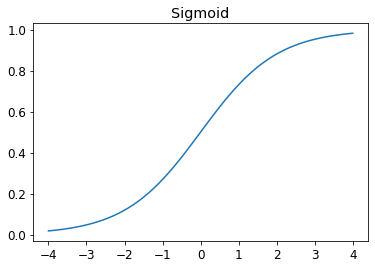

In [32]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [33]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

## A `DataLoader` can take any Python collection and turn it into an iterator over many batches.
## A `Dataset` is a collection that contains tuples of independent and dependent variables.
## When we pass a `Dataset` to a `DataLoader` we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables.

## Now let's put it all together in the form of:

```python
for x,y in dl:
    preds = model(x)
    loss = loss_func(preds, y)
    loss.backward()
    params -= params.grad*lr
```

In [91]:
#1) initialize the parameters
weights = init_params(28*28, 1)
bias = init_params(1)

In [92]:
#2) Calculate the predictions with weights. First let's create some dataloaders so we can process this in mini-batches
dl = DataLoader(dset, batch_size = 256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [93]:
#2) Do the same with the validation set
valid_dl = DataLoader(valid_dset, batch_size = 256)

In [107]:
# create a small batch first for testing
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [112]:
preds = linear1(batch)
preds = preds.view(-1,1)

In [113]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.1606, grad_fn=<MeanBackward0>)

In [114]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784]), tensor(-0.0084), tensor([-0.0597]))

In [126]:
## put that all into a function
def calc_grad(xb, yb, model):
    preds = model(xb)
    preds = preds.view(-1,1)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [116]:
calc_grad(train_x[:4], train_y[:4], linear1)

In [117]:
weights.grad.mean(),bias.grad

(tensor(-0.0167), tensor([-0.1194]))

In [118]:
## don't forget to error out the grads after each calculation as they are a running add to 
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [119]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, lr)
    for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [120]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [ True]])

In [121]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [122]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

In [123]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [124]:
validate_epoch(linear1)

0.4953

In [127]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

TypeError: 'float' object is not callable